**Twitter Sentiment Analysis:**

A Twitter Sentiment Analysis determines negative, positive, or neutral emotions within the text of a tweet using NLP and ML models.These data are useful in understanding the opinion of people on social media for a variety of topics.

In [1]:
# utilities
import re #regex
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer #Lemmatization is the process of reducing the word (running -> run, cats-> cat)

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

Reading and Loading the dataset:

In [2]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv.zip", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

Exploratory Data Analysis (EDA):

In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [6]:
print(f"Length of dataset is {len(df)}")

Length of dataset is 1600000


In [8]:
df.shape

(1600000, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [12]:
df.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


In [13]:
df['target'].unique()

array([0, 4])

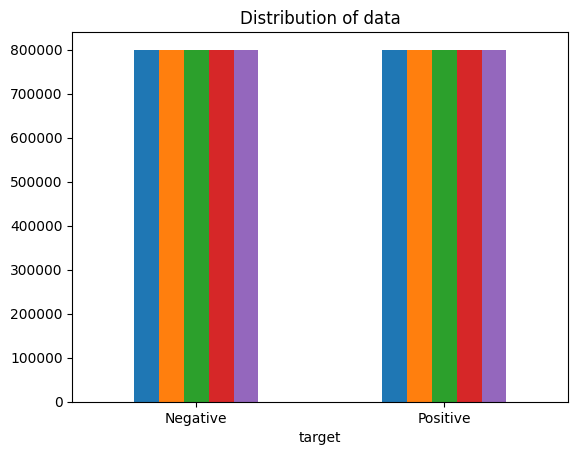

In [15]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
plt.show()

In [16]:
# Storing data in lists.
text = list(df['text'])
sentiment = list(df['target'])

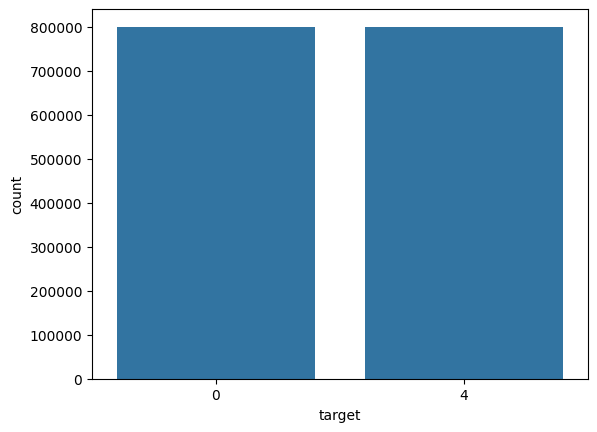

In [17]:
sns.countplot(x='target', data=df);

Data Preprocessing:

In [18]:
data=df[['text','target']]

In [19]:
data.tail(5)

,text,target
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,4


In [20]:
# Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)
data['target'] = data['target'].replace(4,1)

<ipython-input-20-3a16057e415e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [21]:
data['target'].unique()

array([0, 1])

In [22]:
pos_data = data[data['target'] == 1]
neg_data = data[data['target'] == 0]

In [23]:
# Using 1/4th data
pos_data = pos_data.iloc[:int(20000)]
neg_data = neg_data.iloc[:int(20000)]

In [25]:
dataset = pd.concat([pos_data, neg_data])

In [26]:
# Making text to lower case
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

,text
19995,"not much time off this weekend, work trip to m..."
19996,one more day of holidays
19997,feeling so down right now .. i hate you damn h...
19998,"geez,i hv to read the whole book of personalit..."
19999,i threw my sign at donnie and he bent over to ...


In [27]:
# Defining set containing all stopwords in English.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [28]:
# Cleaning and removing the above stop words list from the tweets
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

,text
800000,love @health4uandpets u guys r best!!
800001,im meeting one besties tonight! cant wait!! - ...
800002,"@darealsunisakim thanks twitter add, sunisa! g..."
800003,sick really cheap hurts much eat real food plu...
800004,@lovesbrooklyn2 effect everyone


In [29]:
# Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

,text
19995,not much time off weekend work trip malmï¿½ fr...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent over get but thingee ma...


In [30]:
# Cleaning and removing repeating character
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

,text
19995,not much time off weekend work trip malmï¿½ fr...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent over get but thingee ma...


In [31]:
# Cleaning and removing URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

,text
19995,not much time off weekend work trip malmï¿½ fr...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent over get but thingee ma...


In [32]:
# Cleaning and removing numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

,text
19995,not much time off weekend work trip malmï¿½ fr...
19996,one day holidays
19997,feeling right hate damn humprey
19998,geezi hv read whole book personality types emb...
19999,threw sign donnie bent over get but thingee ma...


In [33]:
# Tokenization of tweet text
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

,text
800000,"[love, healthuandpets, u, guys, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,"[lovesbrooklyn, effect, everyone]"


In [34]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

,text
800000,"[love, healthuandpets, u, guys, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,"[lovesbrooklyn, effect, everyone]"


In [36]:
import nltk
# Download the 'wordnet' resource
nltk.download('wordnet')
# Applying lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text
800000,"[love, healthuandpets, u, guys, r, best]"
800001,"[im, meeting, one, besties, tonight, cant, wai..."
800002,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,"[sick, really, cheap, hurts, much, eat, real, ..."
800004,"[lovesbrooklyn, effect, everyone]"


Splitting into X and y:

In [38]:
X=data.text
y=data.target

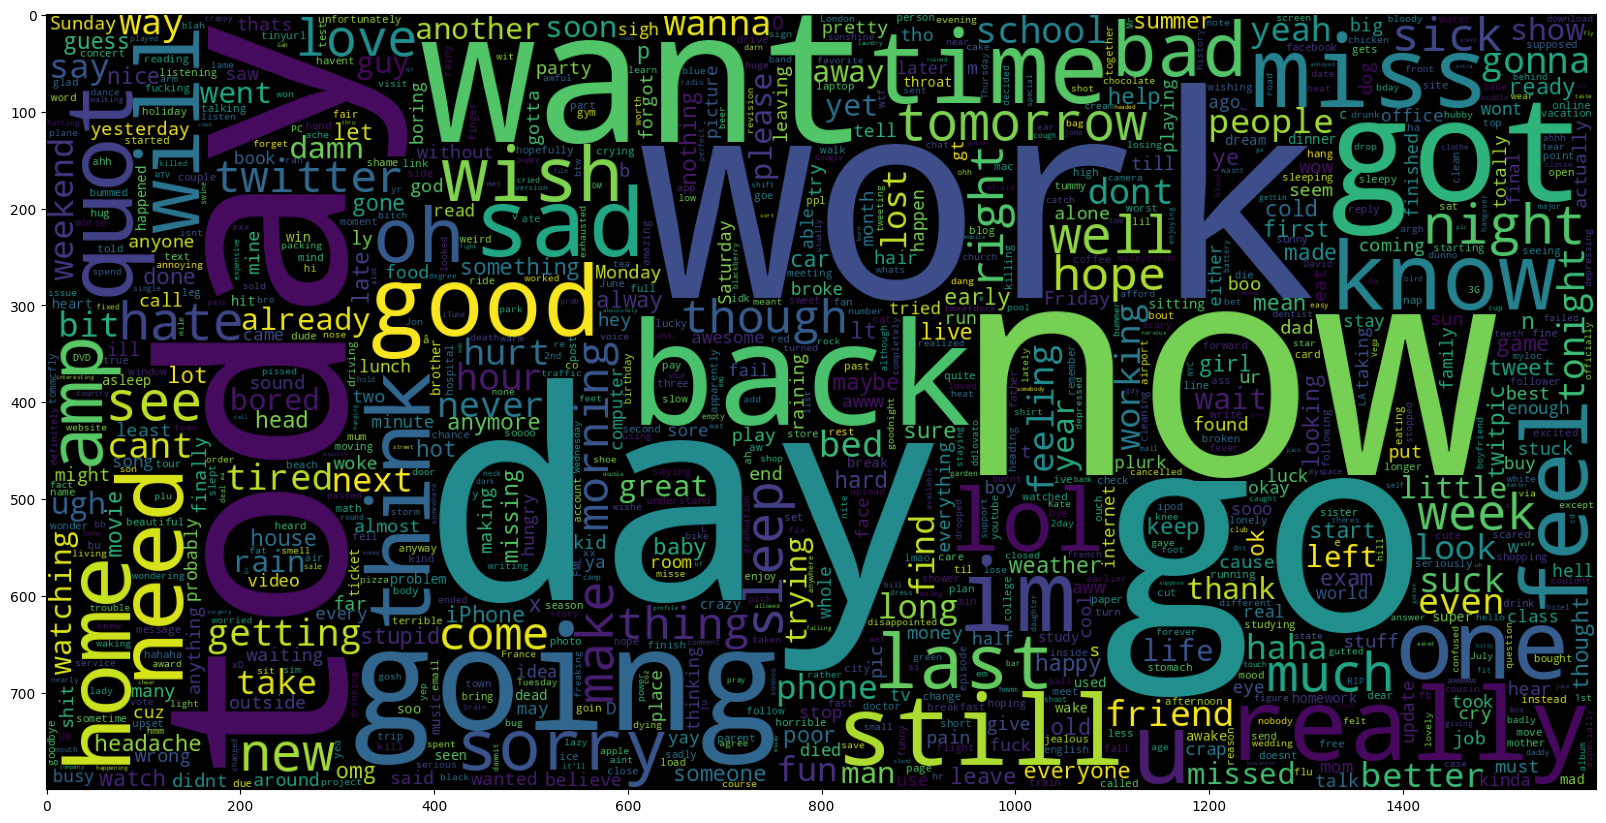

In [39]:
# WordCloud for negative tweets
neg_data = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neg_data))
plt.imshow(wc);

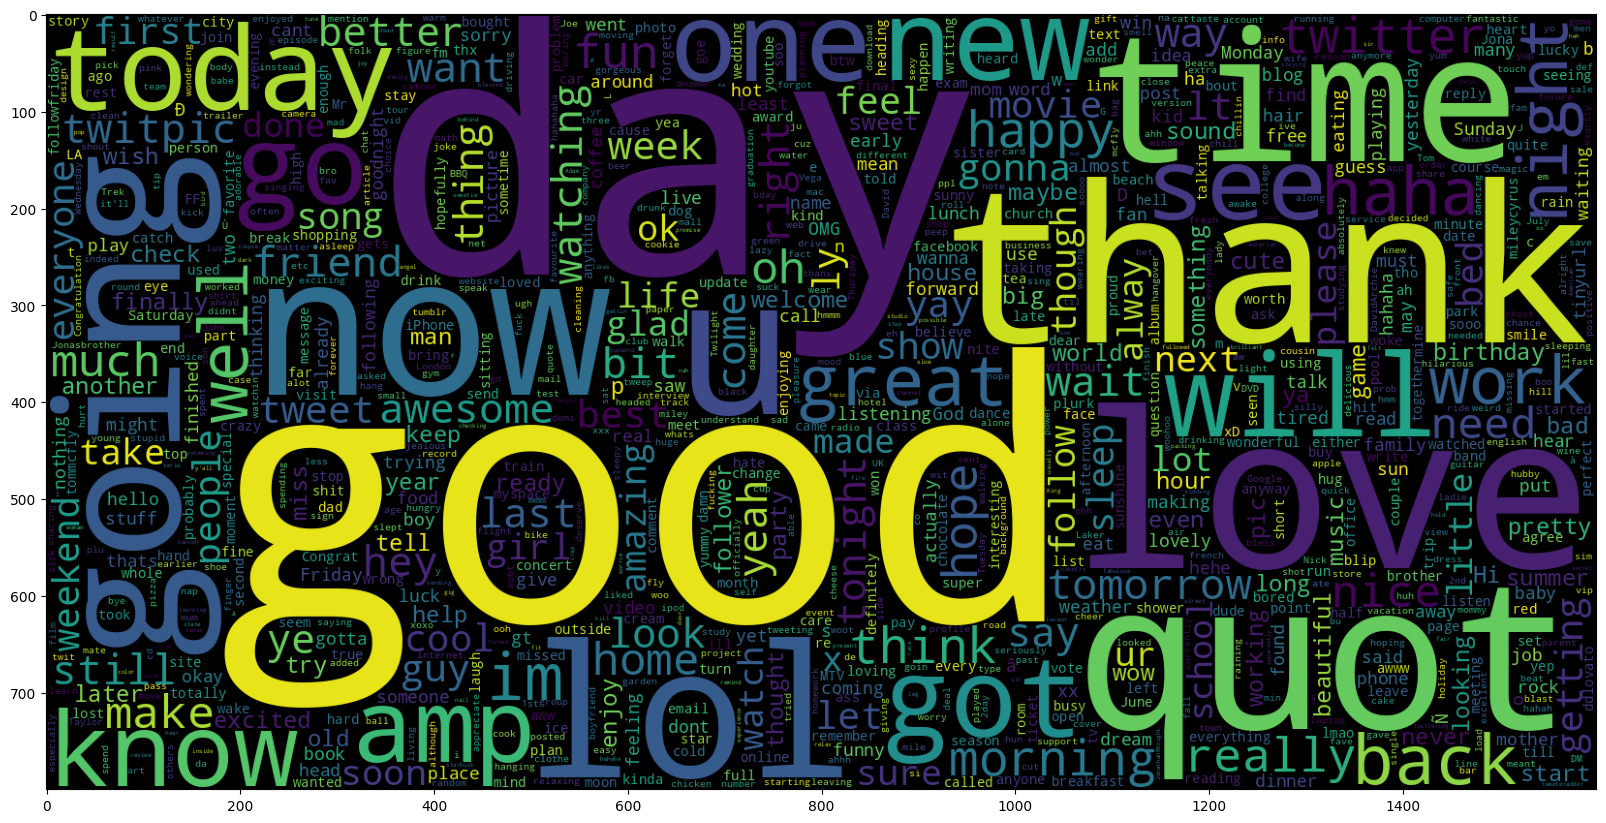

In [40]:
# WordCloud for positive tweets
pos_data = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(pos_data))
plt.figure(figsize = (20,20))
plt.imshow(wc);

Modelling:

95% data for training data and 5% for testing data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.05,
                                                    random_state =42)

In [42]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.vocabulary_))

No. of feature_words:  500000


In [43]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

We will evaluate our models using these evaluation techniques:

Accuracy Score

Confusion Matrix with Plot

ROC-AUC Curve

In [44]:
def model_Evaluate(model):

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']

    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Models:

We will be using 3 models to test our sentiment analysis model:

Bernoulli Naive Bayes Classifier

Support Vector Machine (SVM)

Logistic Regression

Bernoulli Naive Bayes Classifier:

In [45]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

BernoulliNB()

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39999
           1       0.80      0.81      0.80     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



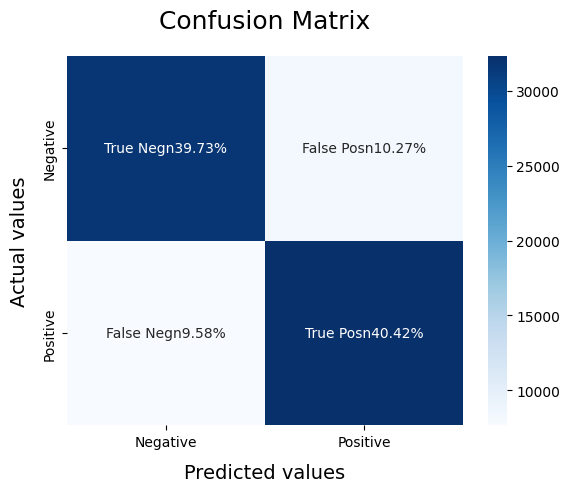

In [46]:
model_Evaluate(BNBmodel)

In [47]:
y_pred1 = BNBmodel.predict(X_test)

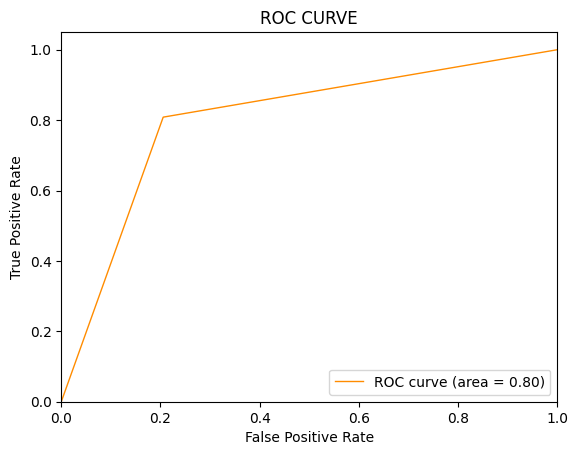

In [48]:
# Plotting the ROC-AUC Curve for model-1

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()


Support Vector Machine (SVM)

In [49]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

LinearSVC()

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39999
           1       0.81      0.82      0.82     40001

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



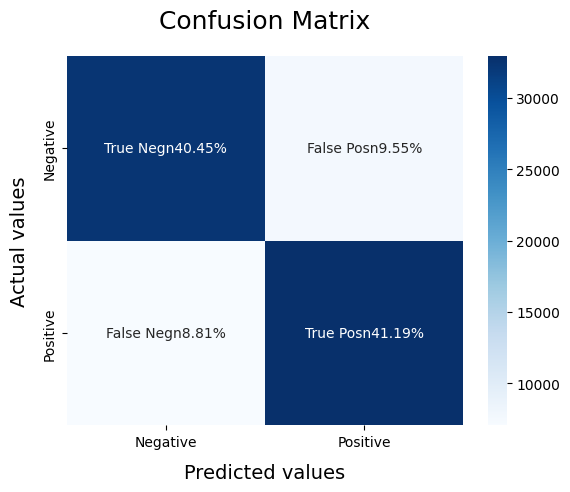

In [50]:
model_Evaluate(SVCmodel)

In [51]:
y_pred2 = SVCmodel.predict(X_test)

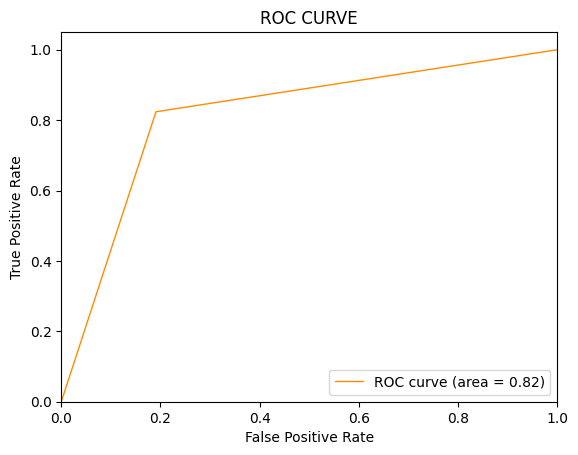

In [52]:
# Plotting the ROC-AUC Curve for model-2

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

Logistic Regression

In [53]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     39999
           1       0.82      0.83      0.83     40001

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



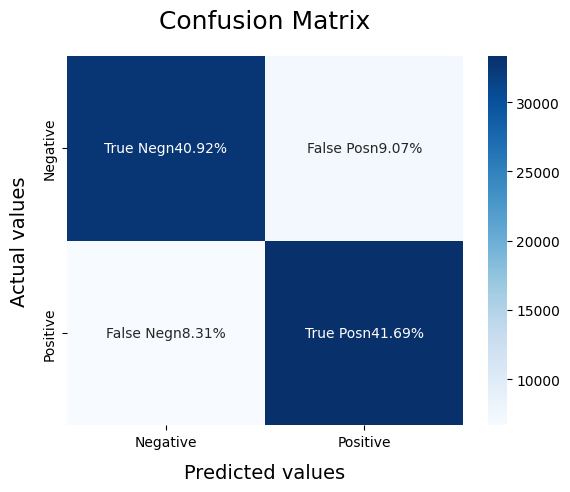

In [54]:
model_Evaluate(LRmodel)

In [55]:
y_pred3 = LRmodel.predict(X_test)

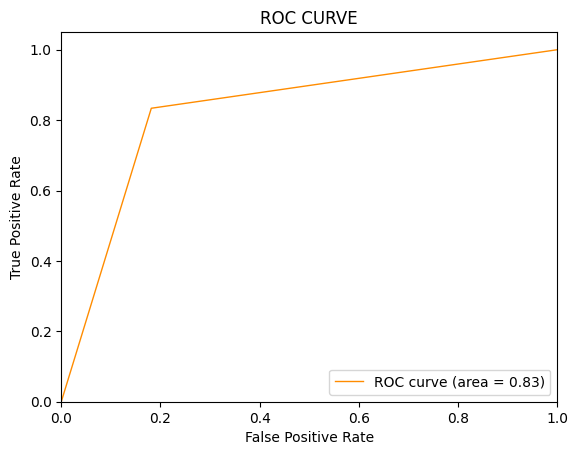

In [56]:
# Plotting the ROC-AUC Curve for model-3

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

Conclusion:

Upon evaluating all the models, we can conclude the following details i.e.

Accuracy: As far as the accuracy of the model is concerned, Logistic Regression performs better than SVM, which in turn performs better than Bernoulli Naive Bayes.

F1-score: The F1 Scores for class 0 and class 1 are :

(a) For class 0: Bernoulli Naive Bayes(accuracy = 0.90) < SVM (accuracy =0.91) < Logistic Regression (accuracy = 0.92)

(b) For class 1: Bernoulli Naive Bayes (accuracy = 0.66) < SVM (accuracy = 0.68) < Logistic Regression (accuracy = 0.69)

AUC Score: All three models have the similar ROC-AUC score.

Therefore, we conclude that the Logistic Regression is the best model for the above-given dataset.